<a href="https://colab.research.google.com/github/Jonny55921/CSCI-167/blob/main/PhishingWebsitesMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from scipy.io import arff
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


These libraries provide a comprehensive toolkit for building and evaluating machine learning models, with PyTorch and torchvision used for deep learning model development and data handling, while scikit-learn assists in data preprocessing, model evaluation, and metrics calculation. Matplotlib and seaborn are utilized for data visualization, and pandas and scipy facilitate data manipulation and handling of specific formats like ARFF. Below is the code to import our dataset from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the dataset
data_path = '/content/drive/MyDrive/Training Dataset.arff'

# Load the .arff file
data, meta = arff.loadarff(data_path)

# Convert to a DataFrame
df = pd.DataFrame(data)

#Test if import worked
for column in df.columns:
    df[column] = df[column].str.decode('utf-8').astype(int)

#Print sample from data set
df.head()


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


The code below is used to setup the data for the model. We will divide the data into a testing and training set. We will then normalize our data and prepare the tensors and data loader for the MLP.

In [ ]:
target_column = 'Result'
X = df.drop(target_column, axis=1)
y = df[target_column]
# Seperates the result tab (phishing or safe) and will be used for calculating accuracy

# Only remap values in y (target column), changes the -1 values to 0 for compatability
y = y.replace({-1: 0, 1: 1})

# Split the training and testing data, 20% of dataset is used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale data before converting to tensors, used to normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to tensors, tensors for training and testing
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


We will create a Multi-Layer Perceptron (MLP) with 4 layers. The first layer will have X input layers by 64 output layers which will be flattened to 64x32, then 32x16 and finally to 16x2 since we are doing binary classification (0 phishy and 1 safe). We will be using the ReLU activation function, Cross Entropy loss function, and the Adam optimization function for our model.

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # First layer
        self.dropout1 = nn.Dropout(0.3)  # Add dropout for regularization
        self.fc2 = nn.Linear(64, 32)    # Second layer
        self.dropout2 = nn.Dropout(0.3)  # Add dropout for regularization
        self.fc3 = nn.Linear(32, 16)    # Third layer
        self.fc4 = nn.Linear(16, 2)  # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))   #First layer goes through ReLU activation function
        x = self.dropout1(x)          # Dropout regularization for the first layer
        x = torch.relu(self.fc2(x))   # Second layer goes through ReLU and then dropout
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)               # Output layer no ReLU activation
        return x

# Using Uniform Xavier Initialization we intialize the weights to ensure varience
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)


# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features
model = MLP(input_size)       # Creates model
model.apply(init_weights)     # Initializes weights

criterion = nn.CrossEntropyLoss() # Algorithm used for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01) # Adam Optimzation algorithm

# Learning rate scheduler will be cut in half every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



Below is the training and evaluation section of the model. We will train the model over 20 epochs.

In [ ]:
# Number of epochs
epochs = 20
# Initialize lists to store metrics
train_losses = []
test_accuracies = []
y_pred = []
y_true = []
y_scores = []  # To store probabilities for Precision-Recall

#Iterate through each epoch to train and keep records of loss and accuracy
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

    # Evaluate test accuracy
    model.eval()
    correct = 0
    total = 0
    y_pred_epoch = []
    y_true_epoch = []
    y_scores_epoch = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            # Collect predictions, true labels, and probabilities
            y_pred_epoch.extend(predicted.cpu().numpy())
            y_true_epoch.extend(y_batch.cpu().numpy())
            y_scores_epoch.extend(probabilities.cpu().numpy())

    accuracy = correct / total
    test_accuracies.append(accuracy * 100)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Collect overall predictions and probabilities after final epoch
    if epoch == epochs - 1:
        y_pred = y_pred_epoch
        y_true = y_true_epoch
        y_scores = y_scores_epoch

    # Update the learning rate scheduler
    scheduler.step()


Epoch 1/20, Loss: 0.22735414452285974
Test Accuracy: 93.22%
Epoch 2/20, Loss: 0.16838173365845793
Test Accuracy: 94.17%
Epoch 3/20, Loss: 0.15246664990909695
Test Accuracy: 94.44%
Epoch 4/20, Loss: 0.14476019683014937
Test Accuracy: 94.08%
Epoch 5/20, Loss: 0.138814718983664
Test Accuracy: 94.71%
Epoch 6/20, Loss: 0.1250854684779629
Test Accuracy: 94.80%
Epoch 7/20, Loss: 0.11449421299218002
Test Accuracy: 94.80%
Epoch 8/20, Loss: 0.11170457389259489
Test Accuracy: 95.21%
Epoch 9/20, Loss: 0.10867568496816425
Test Accuracy: 95.12%
Epoch 10/20, Loss: 0.10480786258327886
Test Accuracy: 95.48%
Epoch 11/20, Loss: 0.10112158594895088
Test Accuracy: 95.48%
Epoch 12/20, Loss: 0.09403490366175475
Test Accuracy: 95.52%
Epoch 13/20, Loss: 0.09228592873626601
Test Accuracy: 95.79%
Epoch 14/20, Loss: 0.08923494342684289
Test Accuracy: 96.07%
Epoch 15/20, Loss: 0.08794724114526262
Test Accuracy: 95.84%
Epoch 16/20, Loss: 0.08252184536049163
Test Accuracy: 95.93%
Epoch 17/20, Loss: 0.082493784591145

Here is the code to visualize the loss and accuracy of the model. We use mat plot to generate a grid using the values from the two lists we created before we ran through the testing data. (train_losses, test_accuracies)

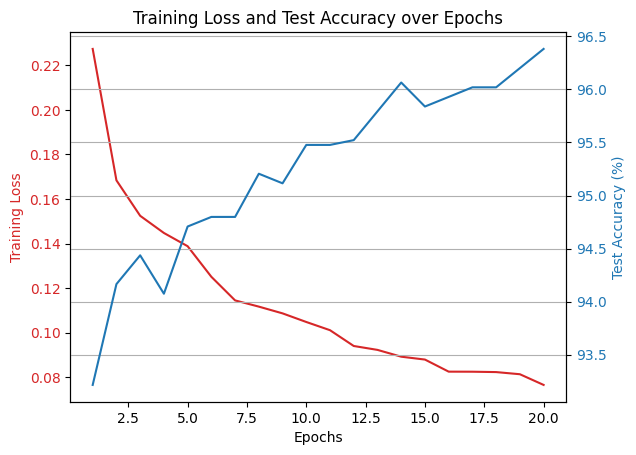

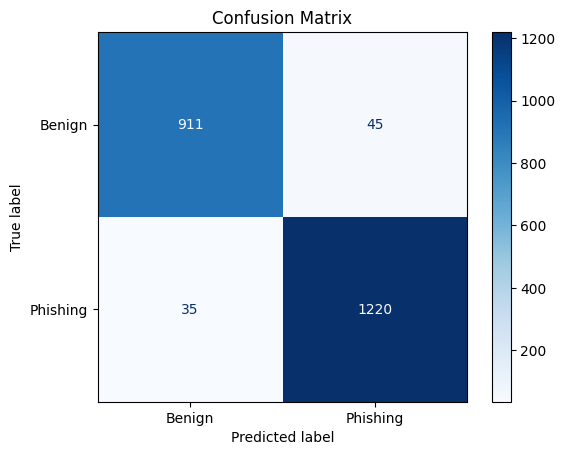

In [ ]:
# Code to create the loss vs accuracy graph below over the epochs

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color="tab:red")
ax1.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()
ax2.set_ylabel("Test Accuracy (%)", color="tab:blue")
ax2.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Training Loss and Test Accuracy over Epochs")
plt.grid()
plt.show()

# Code to create the Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Below is the code to calculate the performance metrics of the code and create a graph to show them. The performance metrics we used are precision, recall, F1 score, and an overall average (macro average).

Precision: 0.96, Recall: 0.97, F1 Score: 0.97


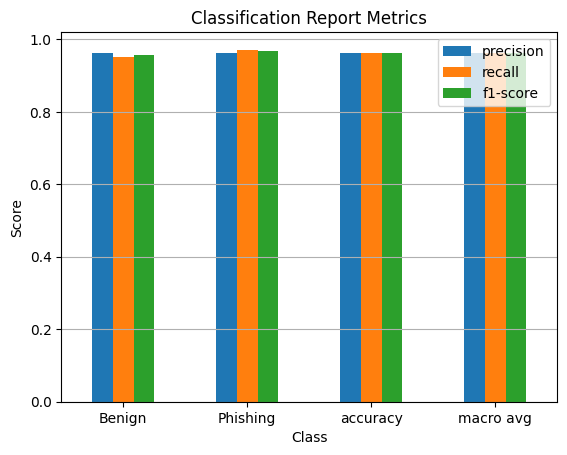

In [ ]:
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

report = classification_report(y_true, y_pred, target_names=["Benign", "Phishing"], output_dict=True)

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot the metrics
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar')
plt.title("Classification Report Metrics")
plt.ylabel("Score")
plt.xlabel("Class")
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.show()